In [1]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
import numpy as np
import random
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

try:
    os.chdir(os.path.join(os.getcwd(), '../../catchgame/'))
except:
    print("already in directory")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"{device} is available")

cuda is available


In [2]:
from modules.dqn.network import QNetworkConv
from world import CatchEnv

n_actions = 3
n_episodes = 1000
batch_size = 512

CATCH_ENV_NUM_STATES = 4
CATCH_ENV_WORLD_SIZE = (84, 84)
CATCH_ENV_POSSIBLE_ACTIONS = [0, 1, 2]

spatial_size = CATCH_ENV_WORLD_SIZE

dqn = QNetworkConv(
    in_channels=CATCH_ENV_NUM_STATES, 
    spatial_size=spatial_size, 
    output_size=len(CATCH_ENV_POSSIBLE_ACTIONS)
).to(device)
dqn_target = QNetworkConv(
    in_channels=CATCH_ENV_NUM_STATES,
    spatial_size=spatial_size,
    output_size=len(CATCH_ENV_POSSIBLE_ACTIONS)
).to(device)

In [3]:
env = CatchEnv()
env.reset_random()
next_state, reward, done = env.step(action=1)
next_state.shape, reward, done

((84, 84, 4), 0, False)

In [4]:
transforms = T.Compose([
    T.ToTensor(),
    T.Resize(spatial_size),
    lambda x: x.unsqueeze(0),
    lambda x: x.type(torch.float32),
])

transforms(next_state).shape

c:\Users\mo\anaconda3\envs\ml_env\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([1, 4, 84, 84])

In [5]:
optimizer = optim.Adam(dqn.parameters(), lr=1e-4)
criterion = nn.SmoothL1Loss()

num_episodes = 1000
epsilon = 0.8
gamma = 0.9
epsilon_decay = 0.99


In [6]:
experiment_log = []
def log(data: dict):
    experiment_log.append(data)
    print("; ".join([f"{k}: {v}" for k, v in data.items()]))

In [7]:
import random
from collections import deque

# Define a replay buffer class to store experiences
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
        
    def add(self, experience):
        self.buffer.append(experience)
        
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, done_flags = zip(*batch)
        return states, actions, rewards, next_states, done_flags

# Initialize the replay buffer
replay_buffer = ReplayBuffer(capacity=10000)

def evaulate(epsilon=0.0, num_episodes=10):
    rewards = []
    for episode in range(num_episodes):
        state = env.reset_random()
        state = transforms(state)
        done = False
        episode_reward = 0
        while not done:
            if random.uniform(0, 1) < epsilon:
                action = random.choice(CATCH_ENV_POSSIBLE_ACTIONS)
            else:
                q_values = dqn(state.to(device))
                action = q_values.argmax().item()
            next_state, reward, done = env.step(action)
            next_state = transforms(next_state)
            episode_reward += reward
            state = next_state
        rewards.append(episode_reward)
    return np.mean(rewards)

def sample_epsilon_exponential_decay(min_epsilon=0.01, max_epsilon=0.9, t=0.0):
    I = max_epsilon
    E = min_epsilon
    return (I - E) * np.power(t - 1, 2) + E

# Define the main training loop
best_performance = evaulate(epsilon=0.0, num_episodes=10)
log({"episode": 0, "epsilon": 0.0, "reward": best_performance})

for episode in tqdm(range(num_episodes)):
    # Initialize the environment and state
    state = env.reset_random()
    state = transforms(state)
    done = False
    
    done_i = 0

    while not done:
        # Choose an action using an epsilon-greedy policy
        if random.uniform(0, 1) < epsilon:
            action = random.choice(CATCH_ENV_POSSIBLE_ACTIONS)
        else:
            q_values = dqn(state.to(device))
            action = q_values.argmax().item()
        
        # Take the action and observe the next state and reward
        next_state, reward, done = env.step(action)
        next_state = transforms(next_state)
        
        # Add the experience to the replay buffer
        replay_buffer.add((state, action, reward, next_state, done))
        
        # Sample a batch of experiences from the replay buffer
        if len(replay_buffer.buffer) > batch_size:
            states, actions, rewards, next_states, done_flags = replay_buffer.sample(batch_size)
            # (batch, 4, 84, 84)
            # [(1, 4, 84, 84), ... ] -> (batch, 4, 84, 84)
            
            states = torch.cat(states).to(device)
            actions = torch.Tensor(actions).type(dtype=torch.int64).to(device)
            rewards = torch.Tensor(rewards).to(device)
            next_states = torch.cat(next_states).to(device)
            done_flags = torch.Tensor(done_flags).to(device)

            # Compute the target Q-values using the DDQN algorithm
            q_values = dqn(states)
            max_actions = q_values.argmax(dim=-1)
            
            with torch.no_grad():
                q_values_target = dqn_target(next_states)
            q_values_target = q_values_target.gather(1, max_actions.unsqueeze(-1)).squeeze(-1)
            q_values_target = rewards + gamma * q_values_target * (1 - done_flags)
            
            # Compute the current Q-values and the loss
            current_q_values = q_values.gather(1, torch.Tensor(actions).unsqueeze(-1)).squeeze(-1)
            loss = criterion(current_q_values, q_values_target.detach())
            
            # Update the DQN network
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Update the target network
            if done_i % 10 == 0:
                dqn_target.load_state_dict(dqn.state_dict())
            done_i += 1
        
        # Update the state
        state = next_state

    # Evaluate the policy and save the results
    if episode % 10 == 0:
        mean_reward = evaulate(epsilon=0.0, num_episodes=10)
        epsilon = sample_epsilon_exponential_decay(t=mean_reward)
        if mean_reward > best_performance:
            best_performance = mean_reward
            torch.save(dqn.state_dict(), "models/dqn_best.pt")
        log({"episode": episode, "mean_reward": mean_reward, "epsilon": epsilon})
      

episode: 0; epsilon: 0.0; reward: 0.2


  0%|          | 1/1000 [00:00<02:29,  6.69it/s]

episode: 0; mean_reward: 0.3; epsilon: 0.44609999999999994


  1%|          | 11/1000 [00:00<00:30, 32.03it/s]

episode: 10; mean_reward: 0.2; epsilon: 0.5796000000000001


  2%|▏         | 21/1000 [00:00<00:26, 37.34it/s]

episode: 20; mean_reward: 0.4; epsilon: 0.3304


  3%|▎         | 31/1000 [00:00<00:25, 38.40it/s]

episode: 30; mean_reward: 0.3; epsilon: 0.44609999999999994


  4%|▍         | 41/1000 [00:01<00:23, 40.14it/s]

episode: 40; mean_reward: 0.2; epsilon: 0.5796000000000001


  5%|▌         | 51/1000 [00:03<01:59,  7.94it/s]

episode: 50; mean_reward: 0.2; epsilon: 0.5796000000000001


  6%|▌         | 61/1000 [00:08<05:52,  2.66it/s]

episode: 60; mean_reward: 0.0; epsilon: 0.9


  7%|▋         | 71/1000 [00:13<07:31,  2.06it/s]

episode: 70; mean_reward: 0.2; epsilon: 0.5796000000000001


  8%|▊         | 81/1000 [00:18<08:02,  1.91it/s]

episode: 80; mean_reward: 0.2; epsilon: 0.5796000000000001


  9%|▉         | 91/1000 [00:22<07:45,  1.95it/s]

episode: 90; mean_reward: 0.2; epsilon: 0.5796000000000001


 10%|█         | 101/1000 [00:27<07:50,  1.91it/s]

episode: 100; mean_reward: 0.6; epsilon: 0.15240000000000004


 11%|█         | 111/1000 [00:33<08:19,  1.78it/s]

episode: 110; mean_reward: 0.4; epsilon: 0.3304


 12%|█▏        | 121/1000 [00:38<08:11,  1.79it/s]

episode: 120; mean_reward: 0.3; epsilon: 0.44609999999999994


 13%|█▎        | 131/1000 [00:43<07:39,  1.89it/s]

episode: 130; mean_reward: 0.2; epsilon: 0.5796000000000001


 14%|█▍        | 141/1000 [00:48<07:12,  1.99it/s]

episode: 140; mean_reward: 0.2; epsilon: 0.5796000000000001


 15%|█▌        | 151/1000 [00:53<07:32,  1.88it/s]

episode: 150; mean_reward: 0.3; epsilon: 0.44609999999999994


 16%|█▌        | 161/1000 [00:58<07:18,  1.91it/s]

episode: 160; mean_reward: 0.5; epsilon: 0.2325


 17%|█▋        | 171/1000 [01:03<07:48,  1.77it/s]

episode: 170; mean_reward: 0.5; epsilon: 0.2325


 18%|█▊        | 181/1000 [01:09<07:42,  1.77it/s]

episode: 180; mean_reward: 0.2; epsilon: 0.5796000000000001


 19%|█▉        | 191/1000 [01:14<07:08,  1.89it/s]

episode: 190; mean_reward: 0.6; epsilon: 0.15240000000000004


 20%|██        | 201/1000 [01:19<07:34,  1.76it/s]

episode: 200; mean_reward: 0.4; epsilon: 0.3304


 21%|██        | 211/1000 [01:24<07:04,  1.86it/s]

episode: 210; mean_reward: 0.3; epsilon: 0.44609999999999994


 22%|██▏       | 221/1000 [01:29<06:56,  1.87it/s]

episode: 220; mean_reward: 0.1; epsilon: 0.7309000000000001


 23%|██▎       | 231/1000 [01:34<06:33,  1.96it/s]

episode: 230; mean_reward: 0.6; epsilon: 0.15240000000000004


 24%|██▍       | 241/1000 [01:40<07:12,  1.76it/s]

episode: 240; mean_reward: 0.2; epsilon: 0.5796000000000001


 25%|██▌       | 251/1000 [01:45<06:31,  1.91it/s]

episode: 250; mean_reward: 0.5; epsilon: 0.2325


 26%|██▌       | 261/1000 [01:50<06:49,  1.81it/s]

episode: 260; mean_reward: 0.2; epsilon: 0.5796000000000001


 27%|██▋       | 271/1000 [01:55<06:20,  1.91it/s]

episode: 270; mean_reward: 0.4; epsilon: 0.3304


 28%|██▊       | 281/1000 [02:00<06:39,  1.80it/s]

episode: 280; mean_reward: 0.3; epsilon: 0.44609999999999994


 29%|██▉       | 291/1000 [02:05<06:17,  1.88it/s]

episode: 290; mean_reward: 0.4; epsilon: 0.3304


 30%|███       | 301/1000 [02:10<06:18,  1.85it/s]

episode: 300; mean_reward: 0.4; epsilon: 0.3304


 31%|███       | 311/1000 [02:16<06:28,  1.77it/s]

episode: 310; mean_reward: 0.4; epsilon: 0.3304


 32%|███▏      | 321/1000 [02:21<06:23,  1.77it/s]

episode: 320; mean_reward: 0.6; epsilon: 0.15240000000000004


 33%|███▎      | 331/1000 [02:26<06:24,  1.74it/s]

episode: 330; mean_reward: 0.5; epsilon: 0.2325


 34%|███▍      | 341/1000 [02:32<06:09,  1.78it/s]

episode: 340; mean_reward: 0.3; epsilon: 0.44609999999999994


 35%|███▌      | 351/1000 [02:37<05:43,  1.89it/s]

episode: 350; mean_reward: 0.8; epsilon: 0.04559999999999999


 36%|███▌      | 361/1000 [02:42<06:15,  1.70it/s]

episode: 360; mean_reward: 0.4; epsilon: 0.3304


 37%|███▋      | 371/1000 [02:47<05:38,  1.86it/s]

episode: 370; mean_reward: 0.7; epsilon: 0.09010000000000001


 38%|███▊      | 381/1000 [02:53<05:56,  1.74it/s]

episode: 380; mean_reward: 0.4; epsilon: 0.3304


 39%|███▉      | 391/1000 [02:58<05:45,  1.76it/s]

episode: 390; mean_reward: 0.6; epsilon: 0.15240000000000004


 40%|████      | 401/1000 [03:04<05:46,  1.73it/s]

episode: 400; mean_reward: 0.8; epsilon: 0.04559999999999999


 41%|████      | 411/1000 [03:09<05:44,  1.71it/s]

episode: 410; mean_reward: 0.4; epsilon: 0.3304


 42%|████▏     | 421/1000 [03:14<05:17,  1.82it/s]

episode: 420; mean_reward: 0.8; epsilon: 0.04559999999999999


 43%|████▎     | 431/1000 [03:20<05:35,  1.70it/s]

episode: 430; mean_reward: 0.7; epsilon: 0.09010000000000001


 44%|████▍     | 441/1000 [03:26<05:32,  1.68it/s]

episode: 440; mean_reward: 0.7; epsilon: 0.09010000000000001


 45%|████▌     | 451/1000 [03:31<05:19,  1.72it/s]

episode: 450; mean_reward: 0.9; epsilon: 0.018899999999999997


 46%|████▌     | 461/1000 [03:37<05:18,  1.69it/s]

episode: 460; mean_reward: 0.9; epsilon: 0.018899999999999997


 47%|████▋     | 471/1000 [03:42<05:19,  1.66it/s]

episode: 470; mean_reward: 0.9; epsilon: 0.018899999999999997


 48%|████▊     | 481/1000 [03:48<05:06,  1.69it/s]

episode: 480; mean_reward: 0.7; epsilon: 0.09010000000000001


 49%|████▉     | 491/1000 [03:54<05:00,  1.69it/s]

episode: 490; mean_reward: 0.7; epsilon: 0.09010000000000001


 50%|█████     | 501/1000 [03:59<04:52,  1.71it/s]

episode: 500; mean_reward: 0.8; epsilon: 0.04559999999999999


 51%|█████     | 511/1000 [04:05<04:46,  1.71it/s]

episode: 510; mean_reward: 0.7; epsilon: 0.09010000000000001


 52%|█████▏    | 521/1000 [04:10<04:37,  1.72it/s]

episode: 520; mean_reward: 0.5; epsilon: 0.2325


 53%|█████▎    | 531/1000 [04:16<04:24,  1.78it/s]

episode: 530; mean_reward: 0.5; epsilon: 0.2325


 54%|█████▍    | 541/1000 [04:21<04:13,  1.81it/s]

episode: 540; mean_reward: 0.6; epsilon: 0.15240000000000004


 55%|█████▌    | 551/1000 [04:26<04:17,  1.75it/s]

episode: 550; mean_reward: 0.7; epsilon: 0.09010000000000001


 56%|█████▌    | 561/1000 [04:32<04:14,  1.72it/s]

episode: 560; mean_reward: 0.8; epsilon: 0.04559999999999999


 57%|█████▋    | 571/1000 [04:38<04:18,  1.66it/s]

episode: 570; mean_reward: 0.7; epsilon: 0.09010000000000001


 58%|█████▊    | 581/1000 [04:43<04:06,  1.70it/s]

episode: 580; mean_reward: 0.5; epsilon: 0.2325


 59%|█████▉    | 591/1000 [04:48<03:54,  1.75it/s]

episode: 590; mean_reward: 0.8; epsilon: 0.04559999999999999


 60%|██████    | 601/1000 [04:54<03:52,  1.72it/s]

episode: 600; mean_reward: 0.7; epsilon: 0.09010000000000001


 61%|██████    | 611/1000 [05:00<03:45,  1.72it/s]

episode: 610; mean_reward: 0.9; epsilon: 0.018899999999999997


 62%|██████▏   | 621/1000 [05:05<03:44,  1.69it/s]

episode: 620; mean_reward: 0.8; epsilon: 0.04559999999999999


 63%|██████▎   | 631/1000 [05:11<03:37,  1.70it/s]

episode: 630; mean_reward: 0.9; epsilon: 0.018899999999999997


 64%|██████▍   | 641/1000 [05:16<03:34,  1.68it/s]

episode: 640; mean_reward: 0.7; epsilon: 0.09010000000000001


 65%|██████▌   | 651/1000 [05:22<03:27,  1.68it/s]

episode: 650; mean_reward: 1.0; epsilon: 0.01


 66%|██████▌   | 661/1000 [05:28<03:18,  1.71it/s]

episode: 660; mean_reward: 0.9; epsilon: 0.018899999999999997


 67%|██████▋   | 671/1000 [05:33<03:13,  1.70it/s]

episode: 670; mean_reward: 0.5; epsilon: 0.2325


 68%|██████▊   | 681/1000 [05:39<03:02,  1.75it/s]

episode: 680; mean_reward: 0.8; epsilon: 0.04559999999999999


 69%|██████▉   | 691/1000 [05:44<03:00,  1.71it/s]

episode: 690; mean_reward: 0.9; epsilon: 0.018899999999999997


 70%|███████   | 701/1000 [05:50<02:57,  1.68it/s]

episode: 700; mean_reward: 0.5; epsilon: 0.2325


 71%|███████   | 711/1000 [05:55<02:42,  1.78it/s]

episode: 710; mean_reward: 0.9; epsilon: 0.018899999999999997


 72%|███████▏  | 721/1000 [06:01<02:46,  1.68it/s]

episode: 720; mean_reward: 0.8; epsilon: 0.04559999999999999


 73%|███████▎  | 731/1000 [06:06<02:39,  1.69it/s]

episode: 730; mean_reward: 0.9; epsilon: 0.018899999999999997


 74%|███████▍  | 741/1000 [06:12<02:35,  1.67it/s]

episode: 740; mean_reward: 0.6; epsilon: 0.15240000000000004


 75%|███████▌  | 751/1000 [06:17<02:22,  1.75it/s]

episode: 750; mean_reward: 0.8; epsilon: 0.04559999999999999


 76%|███████▌  | 761/1000 [06:23<02:20,  1.70it/s]

episode: 760; mean_reward: 0.5; epsilon: 0.2325


 77%|███████▋  | 771/1000 [06:29<02:15,  1.69it/s]

episode: 770; mean_reward: 0.7; epsilon: 0.09010000000000001


 78%|███████▊  | 781/1000 [06:34<02:05,  1.74it/s]

episode: 780; mean_reward: 0.7; epsilon: 0.09010000000000001


 79%|███████▉  | 791/1000 [06:40<02:02,  1.71it/s]

episode: 790; mean_reward: 1.0; epsilon: 0.01


 80%|████████  | 801/1000 [06:45<01:57,  1.70it/s]

episode: 800; mean_reward: 0.8; epsilon: 0.04559999999999999


 81%|████████  | 811/1000 [06:51<01:53,  1.67it/s]

episode: 810; mean_reward: 0.7; epsilon: 0.09010000000000001


 82%|████████▏ | 821/1000 [06:56<01:45,  1.70it/s]

episode: 820; mean_reward: 0.9; epsilon: 0.018899999999999997


 83%|████████▎ | 831/1000 [07:02<01:41,  1.67it/s]

episode: 830; mean_reward: 0.7; epsilon: 0.09010000000000001


 84%|████████▍ | 841/1000 [07:08<01:33,  1.70it/s]

episode: 840; mean_reward: 0.9; epsilon: 0.018899999999999997


 85%|████████▌ | 851/1000 [07:13<01:28,  1.68it/s]

episode: 850; mean_reward: 0.9; epsilon: 0.018899999999999997


 86%|████████▌ | 861/1000 [07:19<01:21,  1.70it/s]

episode: 860; mean_reward: 0.9; epsilon: 0.018899999999999997


 87%|████████▋ | 871/1000 [07:25<01:16,  1.70it/s]

episode: 870; mean_reward: 0.8; epsilon: 0.04559999999999999


 88%|████████▊ | 881/1000 [07:30<01:10,  1.69it/s]

episode: 880; mean_reward: 0.9; epsilon: 0.018899999999999997


 89%|████████▉ | 891/1000 [07:36<01:05,  1.66it/s]

episode: 890; mean_reward: 0.8; epsilon: 0.04559999999999999


 90%|█████████ | 901/1000 [07:42<00:58,  1.70it/s]

episode: 900; mean_reward: 0.9; epsilon: 0.018899999999999997


 91%|█████████ | 911/1000 [07:47<00:53,  1.67it/s]

episode: 910; mean_reward: 0.8; epsilon: 0.04559999999999999


 92%|█████████▏| 921/1000 [07:53<00:46,  1.69it/s]

episode: 920; mean_reward: 1.0; epsilon: 0.01


 93%|█████████▎| 931/1000 [07:58<00:41,  1.67it/s]

episode: 930; mean_reward: 0.9; epsilon: 0.018899999999999997


 94%|█████████▍| 941/1000 [08:04<00:34,  1.70it/s]

episode: 940; mean_reward: 1.0; epsilon: 0.01


 95%|█████████▌| 951/1000 [08:10<00:29,  1.65it/s]

episode: 950; mean_reward: 1.0; epsilon: 0.01


 96%|█████████▌| 961/1000 [08:16<00:23,  1.68it/s]

episode: 960; mean_reward: 0.9; epsilon: 0.018899999999999997


 97%|█████████▋| 971/1000 [08:21<00:17,  1.65it/s]

episode: 970; mean_reward: 0.9; epsilon: 0.018899999999999997


 98%|█████████▊| 981/1000 [08:27<00:11,  1.68it/s]

episode: 980; mean_reward: 0.9; epsilon: 0.018899999999999997


 99%|█████████▉| 991/1000 [08:32<00:05,  1.69it/s]

episode: 990; mean_reward: 0.9; epsilon: 0.018899999999999997


100%|██████████| 1000/1000 [08:38<00:00,  1.93it/s]


In [14]:
# save experiment log where each key is a numpy array
from datetime import datetime
import pandas as pd

runs_folder = "./runs"
run_name = "run-" + datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
os.makedirs(runs_folder, exist_ok=True)
os.makedirs(os.path.join(runs_folder, run_name), exist_ok=True)
keys = experiment_log[0].keys()
for key in keys:
    np.save(os.path.join(runs_folder, run_name, f"{key}.npy"), np.array([log.get(key, None) for log in experiment_log]))

df = pd.DataFrame(experiment_log)
df.to_csv(os.path.join(runs_folder, run_name, "log.csv"), index=False)

In [ ]:
# load and plot all keys into a single plot
import matplotlib.pyplot as plt
keys = ["mean_reward", "epsilon"]

In [15]:
# load best 
dqn.load_state_dict(torch.load("models/dqn_best.pt"))

<All keys matched successfully>

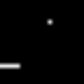

In [60]:
# evluation
env = CatchEnv()
state = env.reset_random()
state = transforms(state)
video = []

while True:
    q_values = dqn(state.to(device))
    action = q_values.argmax().item()
    next_state, reward, done = env.step(action)
    next_state = transforms(next_state)
    state = next_state
    video.append(next_state.squeeze(0))
    if done:
        break

frames = []
video = torch.stack(video)
# shape (k iterations, 4 frames, 84, 84)
# put side to side resulting in (4 * k, 84, 84) without changing the order
video = video.permute(1, 0, 2, 3).reshape(4 * len(video), 84, 84)

# video is of shape (time, 84, 84)
# make a gif and display it
import imageio
from IPython.display import Image

imageio.mimsave("dqn_conv.gif", 255 * video.cpu().numpy())
Image(filename="dqn_conv.gif", format='png')